In [1]:
import recordlinkage

from recordlinkage.datasets import load_febrl2

In [2]:
df, links = load_febrl2(return_links=True)

In [3]:
df = df.fillna("")
df.head(5)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956
rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,19290427,5967384
rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,19631225,3832742


In [4]:
# Indexation step

indexer = recordlinkage.Index()
indexer.block(left_on='given_name')
candidate_links = indexer.index(df)
len(candidate_links)

54769

<br><br> 
This is a deduplication dataset. It's simulated, so we technically know which rows are duplicates, but it will be an illustrative example on how you might tackle such a problem in real life. It's a meaningful problem that a lot of companies face, but it's also an important problem to get right. Having multiple entries for the same user can lead to communication mishaps, having multiple descriptions for the same product can confuse clients and machine learning pipelines might also suffer from bad data quality.

There are multiple sources for data deduplication. So here's a non-exhaustive list. 

- Names might be misspelled phonetically. "Chris" really sounds a lot like "Kris", but the names are different. 
- There might be mishaps with written character recognition. A "g" really looks like a "9". 
- Sometimes values are missing. We might have an entry without a street number, or without a given name. 
- Date formats might mess up the date of birth. 
- People might move to a new home. 

These are all reasons why we need more that `drop_duplicates()` in order to deduplicate our dataset. So let's explore some options.

## Rule Based Approach

Let's start with a relatively "simple" method of detecting duplicates by using the `recordlinkage` library. It's a neet tool that allows you to build "rules" to omit checking every single duplication. 

In [5]:
df.shape[0]

5000

Our dataset has only 5000 examples, but that's 12,497,500 possible combinations we'd need to check! That won't work. So instead we'd like to apply some tricks that will allow us to spend more time looking at the "obvious cases". The `recordlinkage` library has a few solutions for this, but the main technique is known as "blocking". 

In [6]:
import recordlinkage

In [7]:
# Indexation step
indexer = recordlinkage.Index()
indexer.block(left_on='given_name')
candidate_links = indexer.index(df)
len(candidate_links)

54769

By "blocking" on `"given_name"` we're able to only consider links that have the same "given_name". That's progress! 

In [8]:
df.loc[lambda d: d['given_name'] == 'sarah'].head(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-1050-org,sarah,verco,100,de salis street,iron bark ridge,north rocks,4210,nsw,19400826,9844628
rec-2254-dup-2,sarah,webb,39,mcfarlanplace,t int-sec ngarden,coomaleidgup,6023,nsw,19970702,8244083


In [9]:
# Comparison step
compare_cl = recordlinkage.Compare()

compare_cl.exact('given_name', 'given_name', label='given_name')
compare_cl.string('surname', 'surname', method='jarowinkler', threshold=0.85, label='surname')
compare_cl.exact('state', 'state', label='state')
compare_cl.string('address_1', 'address_1', threshold=0.85, label='address_1')

<Compare>

In [10]:
features = compare_cl.compute(candidate_links, df)

# Classification step
matches = features[features.sum(axis=1) > 3]

In [11]:
matches

given_name  surname  state  address_1
rec_id_1       rec_id_2                                             
rec-2254-org   rec-2254-dup-2           1      1.0      1        1.0
rec-370-dup-1  rec-370-dup-0            1      1.0      1        1.0
rec-370-org    rec-370-dup-0            1      1.0      1        1.0
               rec-370-dup-1            1      1.0      1        1.0
rec-589-dup-2  rec-589-dup-0            1      1.0      1        1.0
...                                   ...      ...    ...        ...
rec-3832-org   rec-3832-dup-1           1      1.0      1        1.0
rec-3832-dup-0 rec-3832-dup-1           1      1.0      1        1.0
               rec-3832-org             1      1.0      1        1.0
rec-1885-dup-2 rec-1885-org             1      1.0      1        1.0
rec-134-org    rec-134-dup-2            1      1.0      1        1.0

[822 rows x 4 columns]

<br><br><br><br><br><br><br><br><br>

We can also add some comparison rules to bring this list down to an even shorter set. The four "reasons" listed above can be interpreted as follows:

1. If the `given_name` is the same, that's a reason for duplication.
2. If the `surname` is similar, where similarity is defined by the jarowinkler-string distance (this is a variant of levenstein distance), that's a reason for duplication. There's a threshold value set for this rule.
3. If the `state` is the same, that's a reason for duplication.
4. If the `address_1` is similar, where similarity is defined by the phonetic similarity from the jellyfish library (this is the default distance measure), that's a reason for duplication. There's a threshold value set for this rule.

The goal for these reasons is to reduce our list of links down further. We could make a rule that says something like "if there's an example where at least three rules apply, consider it a duplicate candidate".

In [12]:
features = compare_cl.compute(candidate_links, df)

# Classification step
matches = features[features.sum(axis=1) > 3]

This results in a set of matches shown below. 

In [13]:
matches

given_name  surname  state  address_1
rec_id_1       rec_id_2                                             
rec-2254-org   rec-2254-dup-2           1      1.0      1        1.0
rec-370-dup-1  rec-370-dup-0            1      1.0      1        1.0
rec-370-org    rec-370-dup-0            1      1.0      1        1.0
               rec-370-dup-1            1      1.0      1        1.0
rec-589-dup-2  rec-589-dup-0            1      1.0      1        1.0
...                                   ...      ...    ...        ...
rec-3832-org   rec-3832-dup-1           1      1.0      1        1.0
rec-3832-dup-0 rec-3832-dup-1           1      1.0      1        1.0
               rec-3832-org             1      1.0      1        1.0
rec-1885-dup-2 rec-1885-org             1      1.0      1        1.0
rec-134-org    rec-134-dup-2            1      1.0      1        1.0

[822 rows x 4 columns]

In a real-life scenario, this'd be an excellent point in time to check if these matches indeed correspond with duplicates. So let's set up prodigy for this task. I'll first need to make sure the pairs of items are in a file on disk.

In [14]:
items = []

for ids, _ in matches.iterrows():
    item1 = dict(df.loc[ids[0]])
    item2 = dict(df.loc[ids[1]])
    items.append({"item1": item1, "item2": item2})

In [15]:
items[0]

{'item1': {'given_name': 'sarah',
  'surname': 'webb',
  'street_number': '39',
  'address_1': 'mcfarlan place',
  'address_2': 't int-sect garden',
  'suburb': 'coomalbidgup',
  'postcode': '6023',
  'state': 'nsw',
  'date_of_birth': '19970702',
  'soc_sec_id': '8244083'},
 'item2': {'given_name': 'sarah',
  'surname': 'webb',
  'street_number': '39',
  'address_1': 'mcfarlanplace',
  'address_2': 't int-sec ngarden',
  'suburb': 'coomaleidgup',
  'postcode': '6023',
  'state': 'nsw',
  'date_of_birth': '19970702',
  'soc_sec_id': '8244083'}}

I'll use my personal util library to generate a `.jsonl` file.

In [16]:
from clumper import Clumper

# Clumper(items).write_jsonl("data/recordlinkage_items.jsonl")

## Lessons Learned

From labelling we seem to confirm that the rules come up with sensible suggestions! None of the examples seem unique, buy by labelling we did learn a few things. 

1. There's a few examples that are true duplicates. These can be removed automatically. 
2. There's a few duplicates that may deserve extra attention. It a different social security number is due to a typo it's fine, but a completely different social security number might be an indicator of identity theft. In our example it's a SSN, but in banking I might imagine account numbers to yield similar concerns. 
3. It's good to take the time early to see if you can customise the workflow a bit. That custom template can really shave time in the long run.

## Alternatives 

There is a concern with the current approach. This approach seems to be very precise, but we may be missing out on recall. We've found 822 matches this way, but there may certainly be more in there. 

We could tackle this by playing around with the rules some more. This would certainly be a sensible path going forward. That said, we may also achieve a better recall by trying an alternative technique for finding similar examples. So let's do an encoding trick! 

In [17]:
df.head(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956


In [18]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_extraction.text import CountVectorizer
from simsity.preprocessing import ColumnLister

pipe = make_union(
    make_pipeline(
        ColumnLister("given_name"), 
        CountVectorizer(analyzer="char", ngram_range=(2, 4))
    ),
    make_pipeline(
        ColumnLister("surname"), 
        CountVectorizer(analyzer="char", ngram_range=(2, 4))
    ),
    make_pipeline(
        ColumnLister("address_1"), 
        CountVectorizer(analyzer="char", ngram_range=(2, 4))
    ), 
    make_pipeline(
        ColumnLister("suburb"), 
        CountVectorizer(analyzer="char", ngram_range=(2, 4))
    ),
    make_pipeline(
        ColumnLister("soc_sec_id"), 
        CountVectorizer(analyzer="char", ngram_range=(1, 1))
    )
)

In [19]:
embedded = pipe.fit_transform(df.fillna("")).toarray()

In [20]:
embedded

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 2],
       [0, 0, 0, ..., 0, 0, 1]])

This array is a numeric representation of the original rows in the dataframe. In our case we're doing somewhat simple counting, but if we were dealing with product descriptions we could try out some language models or text embeddings. That's a bit too heavy for our use-case here, so we'll instead proceed with these simple count vectors.

The main point that's quite powerful is that we're able to put a little bit of domain knowledge into our encoding strategy, which is very nice!

## Index 

The "trick" we're about to do, is that we're going to index our embeddings. That way, we can randomly query a datapoint by asking "what are you nearest neighbors". We can look for examples that are within a similirity threshold. This gives us a tuning knob that should allow us to tweak precision vs. recall! 

In [21]:
from annoy import AnnoyIndex

# We need to pass the length of item vector that will be indexed
annoy_index = AnnoyIndex(embedded.shape[1], 'euclidean')
for i in range(embedded.shape[0]):
    annoy_index.add_item(i, embedded[i])

annoy_index.build(10) # 10 trees

True

In [22]:
import random

distances = (10, 10)
threshold = 5

while distances[1] > threshold:
    neighbors, distances = annoy_index.get_nns_by_item(random.randint(0, df.shape[0]), 10, include_distances=True)

df.iloc[neighbors].assign(dist=distances)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,dist
rec_id,,,,,,,,,,,
rec-2267-dup-0,holly,ryan,162,hilder street,vlla 18 pacifci bay resort,manly vale,3109,nsw,19420812,3921086,0.000000
rec-2267-org,holly,ryan,162,hilder street,vlla 18 pacific bay resort,manly vale,3105,nsw,19420812,3921086,0.000000
rec-36-org,chloe,kilby,204,pennefather street,athlone 2,manly vale,4306,nsw,19770724,8718156,8.944272
rec-1253-org,sienna,grobler,50,hilder street,wongon,casula,2251,qld,19550825,3521904,9.055386
rec-3667-org,ethan,ansford,1,hilder street,lambton denture clinic,kirrawee,7331,act,19490925,7846313,9.219544
rec-990-org,flynn,ryan,49,cooks street,perry park hostel,kyogle,2577,nsw,19840513,4805167,9.433981
rec-1755-org,kyle,vidlov,91,goyder street,anstee court,armidale,3101,nsw,19520415,3584921,9.539392
rec-3320-org,holly,nguyen,21,powlett street,,colac,5251,vic,19521023,9143026,9.591663
rec-77-org,lily,hope,2,inkster street,druid's oak,berala,2320,qld,19150907,4726313,9.591663


How many candidates might this generate? Let's guesstimate! 

In [25]:
import tqdm

stats = [] 

for threshold in [3, 4, 5, 6, 7]:
    counter = 0
    for i in tqdm.tqdm(range(500)):
        neighbors, distances = annoy_index.get_nns_by_item(i, 10, include_distances=True)
        for n, dist in zip(neighbors, distances):
            if dist < threshold:
                if n > i:
                    counter += 1
    stats.append({"threshold": threshold, "counts": counter})

100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 22.05it/s]


<AxesSubplot:xlabel='threshold'>

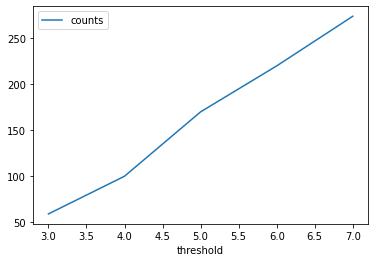

In [26]:
import pandas as pd 

pd.DataFrame(stats).plot("threshold", "counts")

This is neat, we seem to have a "linear knob" to get more examples! 

## Generating Relevant Examples. 

We can use this system to look for links that we did not find before. Let's see what these look like.

In [27]:
before_list = []

for ids, _ in matches.iterrows():
    before_list.append(dict(df.loc[ids[0]]))
    before_list.append(dict(df.loc[ids[1]]))

In [28]:
def seen_before(main, before):
    for b in before:
        if b['given_name'] == main['given_name']:
            return True
    return False

In [29]:
retry = True
threshold = 5

while retry:
    neighbors, distances = annoy_index.get_nns_by_item(random.randint(0, df.shape[0]), 10, include_distances=True)
    main = dict(df.iloc[neighbors[0]])
    if distances[1] < 5:
        retry = False
    if seen_before(main, before_list):
        retry = True

df.iloc[neighbors].assign(dist=distances)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,dist
rec_id,,,,,,,,,,,
rec-1629-dup-0,abbry,purtell,206,lomatia place,northbank caravan park,seymour,4130,nsw,19540518,4803304,0.000000
rec-1629-dup-1,abbey,purtell,206,lomatia place,northbank varavan park,seymour,4130,nsw,,4803304,3.464102
rec-1629-org,abbey,purtell,206,lomatia place,northbank caravan park,seymour,4130,nsw,19540518,4803304,3.464102
rec-1629-dup-2,abbey,purtelk,206,lomatia place,northbank caravan park,seymour,4130,nsw,19540518,4803304,4.242640
rec-780-org,james,zokalj,28,webb place,professional centre,seymour,3393,nt,19291117,6336579,9.695360
rec-1920-org,amy,pegg,18,mcrae place,,moree,2550,wa,19780630,1480713,9.949874
rec-2635-dup-0,ebony,,31,ippia place,mororcdong,stalbans,4030,nsw,19670215,2013176,10.198039
rec-589-dup-1,saah,reid,1,,creston,larnok,5162,nsw,19710725,6614340,10.198039
rec-1864-org,samuel,reid,12,saw place,irrigation farm,lalor,2541,qld,19141004,4489087,10.198039


In [30]:
df = df.assign(row_number=range(df.shape[0]))

In [31]:
import tqdm 

threshold = 8
data = [] 

In [32]:
for i in tqdm.tqdm(range(df.shape[0])):
    neighbors, distances = annoy_index.get_nns_by_item(i, 10, include_distances=True)
    main = dict(df.iloc[neighbors[0]])
    if distances[1] < threshold:
        if not seen_before(main, before_list):
            subset = (df
                      .iloc[neighbors]
                      .assign(dist=distances)
                      .loc[lambda d: d['dist'] < threshold]
                      .loc[lambda d: d['row_number'] > main['row_number']]
                      .drop(columns=["row_number", "dist"])
                      .to_dict(orient='records'))
            for item in subset:
                data.append({"item1": main, "item2": item})

100%|████████████████████████████████████████████████████████████████████████| 5000/5000 [03:43<00:00, 22.38it/s]


In [33]:
len(data)

283

Nice. It seems this new trick is able to find more examples that we did not have before! Let's now label these.

In [34]:
# (Clumper(data)
#   .mutate(item1=lambda d: {k:v for k, v in d['item1'].items() if k != "row_number"})
#   .write_jsonl("data/nn_trick_items.jsonl"))

## One Last Trick 

We just labelled some more, and we can do something interesting with the labels. We can train a classifier! 

That way we can perhaps find some more examples that we would not otherwise find! 

In [35]:
import pandas as pd
from clumper import Clumper
from prodigy.components.db import connect

db = connect() 

labels = (Clumper(db.get_dataset("dedup-demo"))
   .keep(lambda d: d['answer'] == 'accept',
         lambda d: len(d['accept']) > 0)
   .select('item1', 'item2', 'accept')
   .mutate(accept=lambda d: d['accept'][0])
   .collect())

In [36]:
df1 = pd.DataFrame([i["item1"] for i in labels])
df2 = pd.DataFrame([i["item2"] for i in labels])
lab = [i["accept"] for i in labels]

In [37]:
X1 = pipe.transform(df1).todense()
X2 = pipe.transform(df2).todense()

In [38]:
import numpy as np

X_train = np.array(np.abs(X1 - X2))
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [42]:
X_train.shape

(137, 33788)

In [47]:
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(class_weight="balanced", loss="log").fit(X_train, lab)

In [53]:
import tqdm 

threshold = 10
data = [] 

In [54]:
for i in tqdm.tqdm(range(df.shape[0])):
    neighbors, distances = annoy_index.get_nns_by_item(i, 10, include_distances=True)
    main = dict(df.iloc[neighbors[0]])
    # Ensure that we have X data for the original datapoint
    main_x = pipe.transform(df.iloc[[neighbors[0]]]).toarray()
    if distances[1] < threshold:
        if not seen_before(main, before_list):
            # Only consider a subset
            subset = (df
                      .iloc[neighbors]
                      .assign(dist=distances)
                      .loc[lambda d: d['dist'] < threshold]
                      .loc[lambda d: d['row_number'] > main['row_number']]
                      .drop(columns=["row_number", "dist"]))
            
            # Ensure that we have X data for the nearest neighbors
            subset_x = pipe.transform(subset).toarray()
            
            # Because of the "i < j" effect we may have an empty subset
            if len(subset) > 0:
                # Use a trained model to increase the odds of getting duplicates
                preds = lr.predict(np.abs(main_x - subset_x))
                for pred, item in zip(preds, subset.to_dict(orient='records')):
                    # Duplicates only
                    if pred == "duplicate":
                        data.append({"item1": main, "item2": item})

100%|████████████████████████████████████████████████████████████████████████| 5000/5000 [03:49<00:00, 21.80it/s]


In [59]:
len(data)

809

In [60]:
data[-1]

{'item1': {'given_name': 'benkovic',
  'surname': 'matthew',
  'street_number': '20',
  'address_1': 'coutie place',
  'address_2': 'redwood village',
  'suburb': 'lismore south',
  'postcode': '3350',
  'state': 'vic',
  'date_of_birth': '19110228',
  'soc_sec_id': '9415905',
  'row_number': 4652},
 'item2': {'given_name': 'matthew',
  'surname': 'benkovic',
  'street_number': '20',
  'address_1': 'coutie place',
  'address_2': 'redwood village',
  'suburb': 'lismore south',
  'postcode': '3350',
  'state': 'vic',
  'date_of_birth': '19110228',
  'soc_sec_id': '9415905'}}